In [1]:
from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
#import mpld3
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

#import missingno as msno
#import pandas_profiling

#import hdbscan
from sklearn.datasets import make_blobs
import time

In [2]:
def save_subgroup(dataframe, g_index, subgroup_name, prefix='../RedCard/'):
    save_subgroup_filename = "".join([prefix, subgroup_name, ".csv.gz"])
    dataframe.to_csv(save_subgroup_filename, compression='gzip')
    test_df = pd.read_csv(save_subgroup_filename, compression='gzip', index_col=g_index)
    
    # Test that we recover what we send in
    
    if dataframe.equals(test_df):
        print("Test passed: we recovered the equivalent subgroup dataframe")
    else:
        print("Warning -- equivalence test !!! Double-check.")

In [3]:
def load_subgroup(filename, index_col=[0]):
    return pd.read_csv(filename, compression='gzip', index_col=index_col)

## Players

In [4]:
players = load_subgroup('../RedCard/players.csv.gz')

In [5]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25


In [6]:
players.shape

(2053, 7)

In [7]:
players.isna().sum()

birthday      0
height       20
weight       80
position    367
photoID     468
rater1      468
rater2      468
dtype: int64

Significant number of players do not have a skin-tone rating from atleast 1 rater. Are they missing in both? Since this is the feature we are supposed to be answering against - it's an important thing to figure out early. Let's see if there's a correlated pattern in how the data is missing for this table:

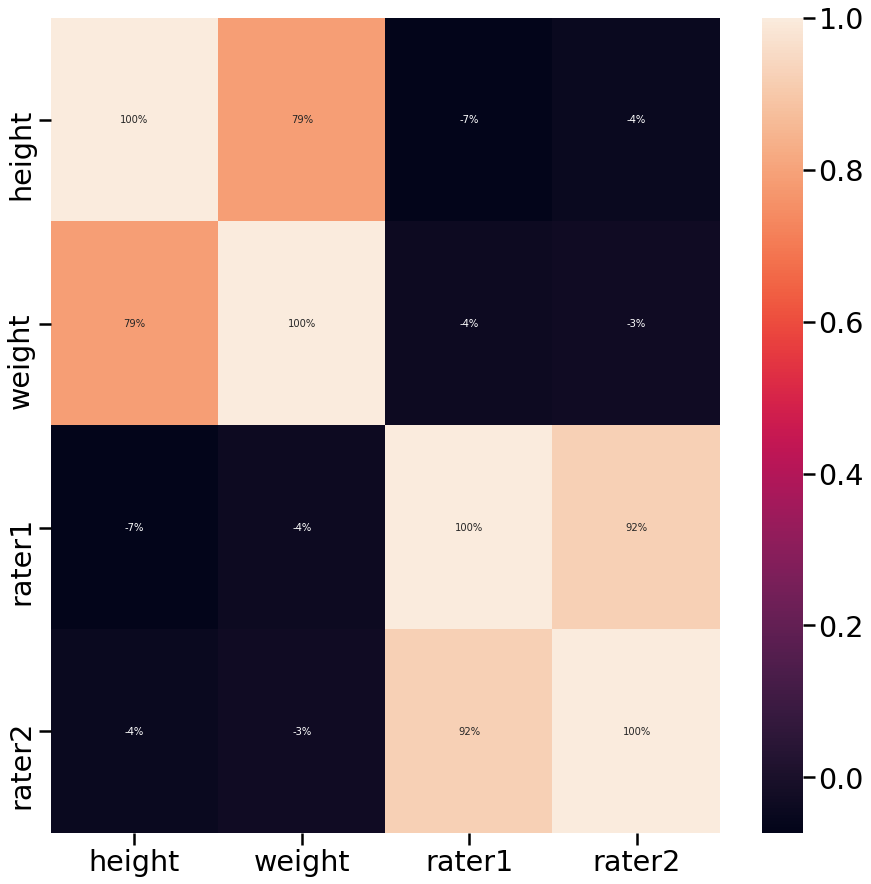

In [13]:
plt.figure(figsize=(15,15)) # resizing the figure for better view
sns.heatmap(players.iloc[:,1:7].corr(), annot = True, fmt = '.0%')

In [28]:
print("All players:", len(players))
print("Rater1 nulls:", len(players[(players.rater1.isnull())]))
print("Rater2 nulls:", len(players[(players.rater2.isnull())]))
print("Both nulls:", len(players[(players.rater1.isnull()) & (players.rater2.isnull())]))
print()
print("rater1:", players['rater1'].isna().sum())
print("rater2:", players['rater2'].isna().sum())
print("Both:", players['rater1'].isna().sum() & players['rater2'].isna().sum())

All players: 2053
Rater1 nulls: 468
Rater2 nulls: 468
Both nulls: 468

rater1: 468
rater2: 468
Both: 468


In [29]:
players = players[players.rater1.notnull()]
players.shape

(1585, 7)

#### We have removed 468 players who did not have any skin-tome rating

In [30]:
players.isna().sum()

birthday      0
height        3
weight       21
position    152
photoID       0
rater1        0
rater2        0
dtype: int64

Each remaining player in the table has 2 skin-tone ratings - are they sufficiently close that they can be combined?

#### Thus, Correlation between Rater1 and Rater2

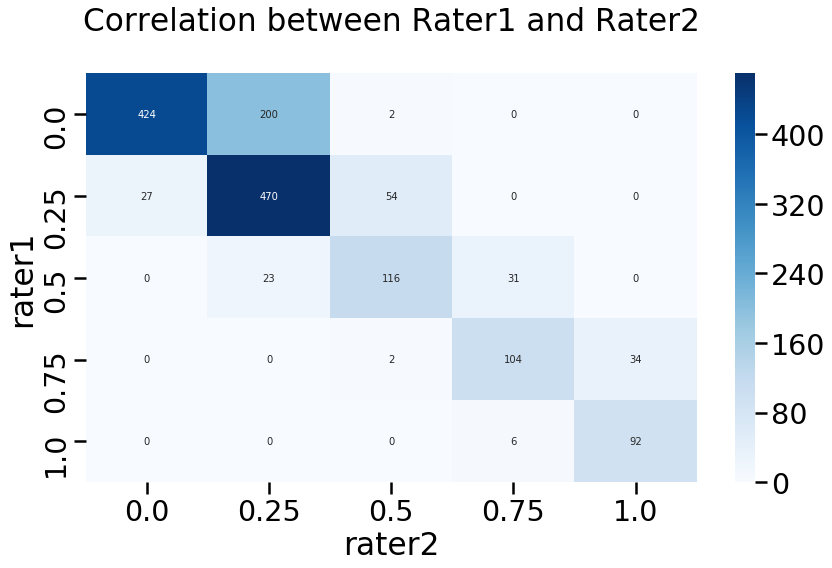

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap='Blues', annot=True, fmt='d', ax=ax)
ax.set_title("Correlation between Rater1 and Rater2\n")
fig.tight_layout()

Diagonal is where both raters agree, off-diagonal is where there is disagreement

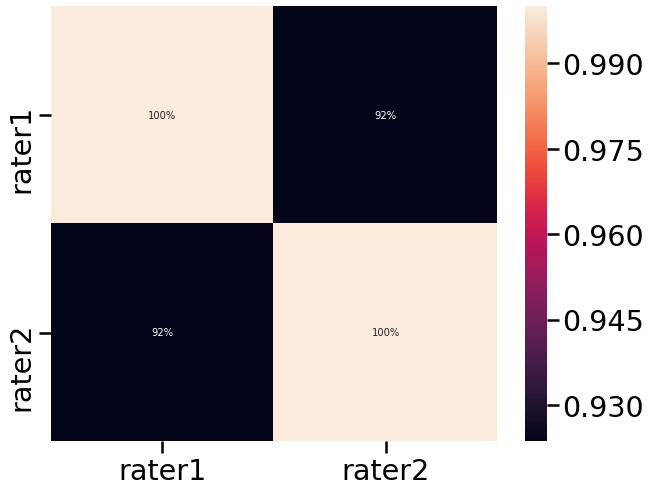

In [50]:
plt.figure(figsize=(10,8)) # resizing the figure for better view
sns.heatmap(players.iloc[:,4:7].corr(), annot = True, fmt = '.0%')

From the above 2 plots, its safe to say that both raters largely agree. Plot 1 is more detailed as it shows at which rating the raters agree/disagree

Hence, we can create a new column which will be the mean of the 2 ratings

In [45]:
players['skintone'] = players[['rater1','rater2']].mean(axis=1)
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone
playerShort,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250


### Visualize distributions of Univariate Features

What is the skintone distribution?

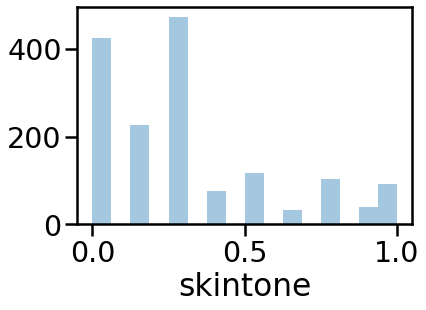

In [46]:
sns.distplot(players.skintone, kde=False)

### Positions
Might the players' position correlate with the baseline susceptibility to redcards? Likely that a defender would have a higher rate than a goalkeeper, for example

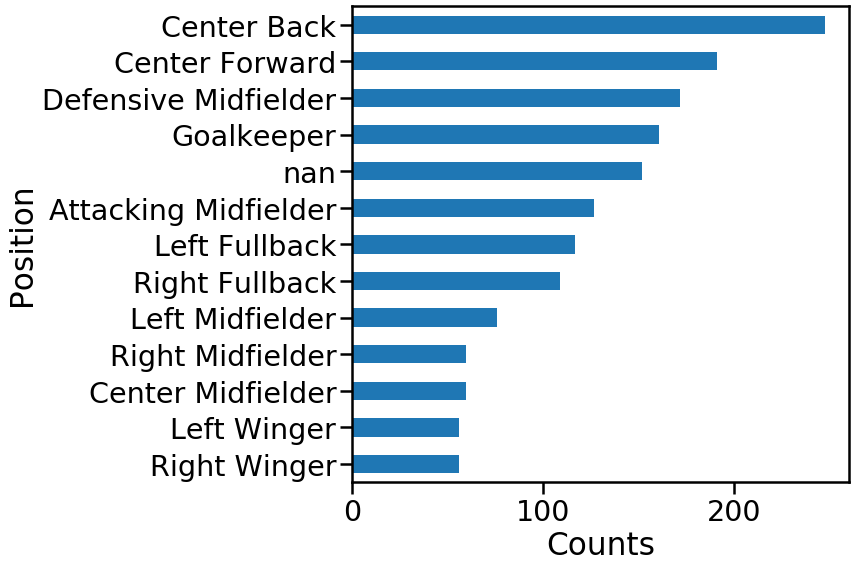

In [52]:
MIDSIZE = (12,8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players.position.value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("Position")
ax.set_xlabel("Counts")
fig.tight_layout()

In [53]:
players['position'].isna().sum()

152

Possibility of getting red/yellow cards to Left Winger and Right Winger is same, hence they can be clubbed.
### Create higher level categories
Recommandation:
- create a new column
- don't overwrite the original data in case you need it or decide later that the higher level category is not useful

The positions can be split up by their primary roles

In [55]:
position_types = players.position.unique()
position_types

array(['Center Back', 'Attacking Midfielder', 'Right Midfielder',
       'Center Midfielder', 'Goalkeeper', 'Defensive Midfielder',
       'Left Fullback', nan, 'Left Midfielder', 'Right Fullback',
       'Center Forward', 'Left Winger', 'Right Winger'], dtype=object)

In [56]:
defense = ['Center Back','Defensive Midfielder','Left Fullback','Right Fullback']
midfield = ['Right Midfielder','Center Midfielder','Left Midfielder']
forward = ['Attacking Midfielder','Left Winger','Right Winger','Center Forward']
keeper = ['Goalkeeper']

# modifying dataframes - adding the aggregated position categorical position_agg
players.loc[players['position'].isin(defense), 'position_agg'] = "Defense"
players.loc[players['position'].isin(midfield), 'position_agg'] = "Midfield"
players.loc[players['position'].isin(forward), 'position_agg'] = "Forward"
players.loc[players['position'].isin(keeper), 'position_agg'] = "Keeper"


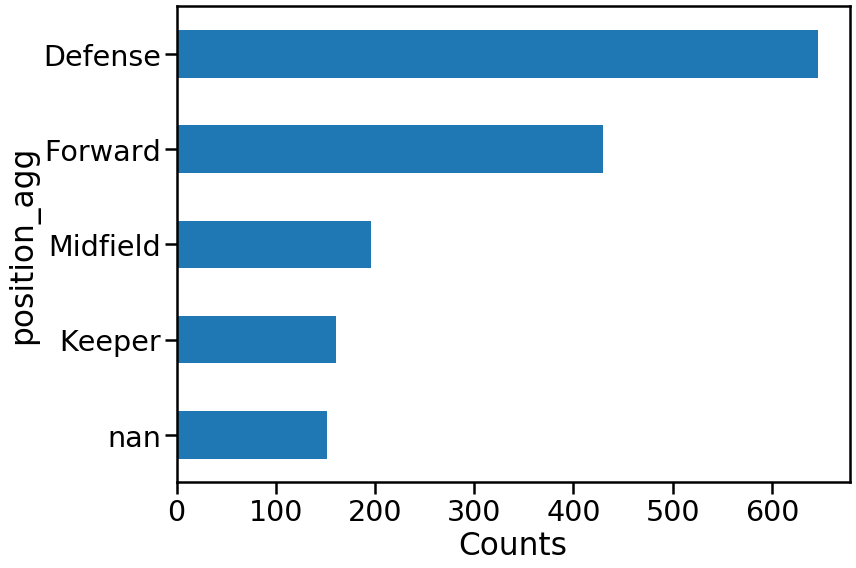

In [57]:
MIDSIZE = (12,8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players['position_agg'].value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("position_agg")
ax.set_xlabel("Counts")
fig.tight_layout()

In [59]:
players.head(10)

,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg
playerShort,,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125,Defense
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125,Forward
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250,Midfield
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000,Midfield
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250,Defense
abdou-traore_2,17.01.1988,180.0,74.0,Right Midfielder,102005.jpg,0.75,0.75,0.750,Midfield
abdoulaye-diallo_2,30.03.1992,189.0,80.0,Goalkeeper,158172.jpg,0.75,1.00,0.875,Keeper
abdoulaye-keita_2,19.08.1990,188.0,83.0,Goalkeeper,148612.jpg,0.75,1.00,0.875,Keeper
abdoulwhaid-sissoko,20.03.1990,180.0,68.0,Defensive Midfielder,134483.jpg,1.00,1.00,1.000,Defense


### Height and Weight
It is possible that size might correspond with redcards

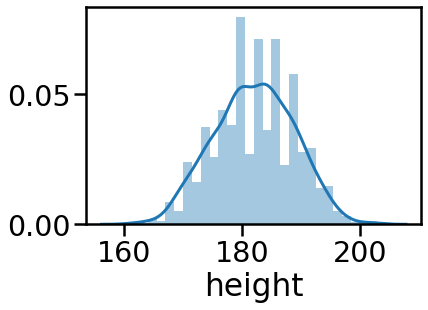

In [60]:
sns.distplot(players.height.dropna())

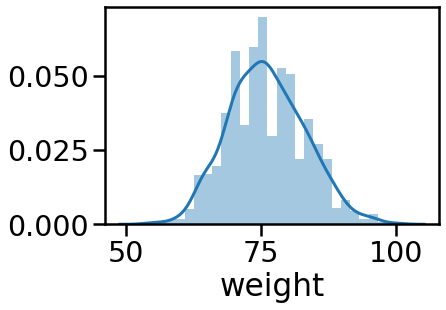

In [61]:
sns.distplot(players.weight.dropna())

### Examine pair-wise relationships
Take a look at measures that will let you quickly see if there are problems or opportunities in the data

In [63]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023423924278>,
      dtype=object)

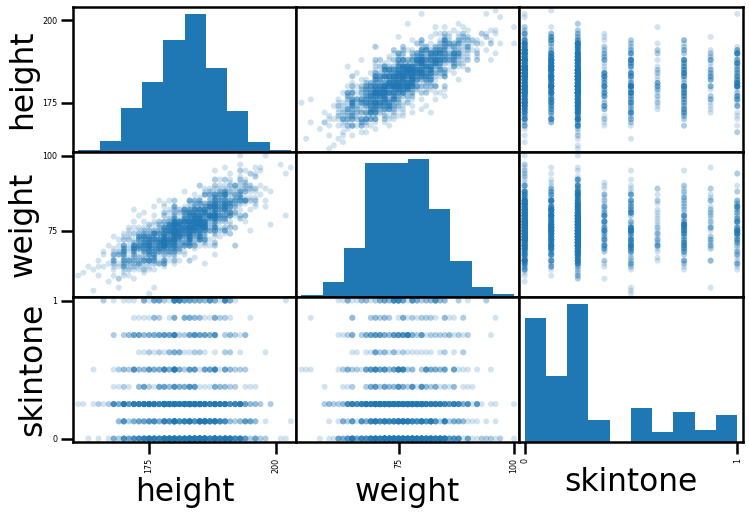

In [66]:
fig, ax = plt.subplots(figsize=MIDSIZE)
scatter_matrix(players[['height','weight','skintone']], alpha=0.2, diagonal='hist', ax=ax)